# Train MLP using rain gauge data
Uses rolling median for detrending

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view # for sliding window
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed # parallell code, for faster life.. 

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score
import tqdm 
onehot = OneHotEncoder(sparse_output=True)

In [3]:
# Read train dataset (coordinates removed)
ds_cmls = xr.open_dataset("data/train_rg.nc")

# get cml names as numpy array (used in code later)
train_test = ds_cmls.cml_id.data

In [4]:
# Calculate nomralized trsl, this fixes stationarity problems such as sudden change of baseline
ds_cmls['trsl_norm'] = (ds_cmls.trsl - ds_cmls.trsl.rolling(time = 12*60, min_periods=2 * 60, center = True).median())


## Determine optimal hyperparameters using crossvalidation

In [5]:
# Define functions for running MLP training in parallell
def train_model(learning_rate, regularization, hidden_layer_sizes, activation, X, Y_onehot, X_val, Y, Y_val):
    dnn = MLPClassifier(learning_rate_init=learning_rate, 
                        alpha=regularization, 
                        #max_iter=600, 
                        activation=activation,
                        solver='adam',
                        verbose=False,
                        hidden_layer_sizes=hidden_layer_sizes)

    dnn.fit(X, Y_onehot)
    dnn_ypred_train = np.array(np.argmax(dnn.predict(X), axis=1)).astype(bool).ravel()  # de one-hot
    dnn_ypred_test = np.array(np.argmax(dnn.predict(X_val), axis=1)).astype(bool).ravel()

    train_mcc = matthews_corrcoef(Y.ravel(), dnn_ypred_train)
    test_mcc = matthews_corrcoef(Y_val.ravel(), dnn_ypred_test)

    return train_mcc, test_mcc

def clf_pred(X, X_val, Y, Y_val, learning_rate, regularization, hidden_layer_sizes, activation):
    Y_onehot = onehot.fit_transform(Y)
    train_mcc = np.zeros((len(learning_rate), len(regularization)))
    test_mcc = np.zeros((len(learning_rate), len(regularization)))

    # Define a function to parallelize
    def process_params(i, j):
        return train_model(learning_rate[i], regularization[j], hidden_layer_sizes, activation, X, Y_onehot, X_val, Y, Y_val)

    # Parallelize the training loop
    results = Parallel(n_jobs=-1)(delayed(process_params)(i, j) for i in range(len(learning_rate)) for j in range(len(regularization)))
    
    # Unpack the results
    for index, (i, j) in enumerate([(i, j) for i in range(len(learning_rate)) for j in range(len(regularization))]):
        train_mcc[i][j], test_mcc[i][j] = results[index]

    return train_mcc, test_mcc

# when training against Norwegian disdrometers it was beneficiary to set window_size to 60
def smooth_binary_array(arr, window_size=1):
    # Create a kernel for smoothing, e.g., [1, 1, 1] for a simple moving average
    kernel = np.ones(window_size, dtype=bool)
    
    # Use convolution to smooth the array
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    
    # Convert non-zero values to True
    smoothed_arr = smoothed_arr > 0
    
    return smoothed_arr

In [6]:
# Define hyperparameters to test
hidden_layer_sizes = [
    [1],
    [10],
    [20],
    [70],
    [5, 5],
    [10, 10],
    [50, 50],
    [100, 100]
]

learning_rate = np.logspace(-7, 0, 7)
regularization = np.linspace(0, 0.7, 5)

windowsize = 40 # found to be ok

In [7]:
# Setup k-fold crossvalidation
k_splits = 5
from sklearn.model_selection import KFold
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
fold_indices = list(kf.split(train_test))

In [8]:
# train mlp on all hyperparameters (this can take several days if you have many hyperparameters)
res_train_xval_relu = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])
res_test_xval_relu = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])

res_train_xval_logistic = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])
res_test_xval_logistic = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])

for j, hls in enumerate(hidden_layer_sizes):    
    for i, (train_idx, val_idx) in enumerate(fold_indices):
        train = train_test[train_idx]    
        test = train_test[val_idx] # validation set

        # prepare TRAIN dataset:
        Y_train = np.vstack(np.array([(ds_cmls.sel(cml_id = train).isel(
            cml_id = i, sublink_id = 0).gauge_wet).values.reshape(-1, 1) for i in range(
            ds_cmls.sel(cml_id = train).cml_id.size)]))

        X_train = []
        x_start = np.ones([int(windowsize/2), windowsize*2])*np.nan
        x_end = np.ones([int(windowsize/2)- 1, windowsize*2])*np.nan

        for link_i in range(ds_cmls.sel(cml_id = train).cml_id.size):
            sliding_window_ch1 = sliding_window_view(ds_cmls.sel(
                cml_id = train).isel(cml_id = link_i, sublink_id = 0).trsl_norm.values, window_shape = windowsize)
            sliding_window_ch2 = sliding_window_view(ds_cmls.sel(
                cml_id = train).isel(cml_id = link_i, sublink_id = 1).trsl_norm.values, window_shape = windowsize)

            X_train.append(np.vstack([x_start, np.hstack([sliding_window_ch1, sliding_window_ch2]), x_end]))
        X_train = np.vstack(X_train)
        
        # remove nan
        indices = np.argwhere(~np.isnan(X_train).any(axis = 1)).ravel()
        X_train = X_train[indices, :]
        Y_train = Y_train[indices]
        
        # prepare TEST dataset:
        Y_test = np.vstack(np.array([(ds_cmls.sel(cml_id = test).isel(
            cml_id = i, sublink_id = 0).gauge_wet).values.reshape(-1, 1) for i in range(
            ds_cmls.sel(cml_id = test).cml_id.size)]))

        X_test = []
        x_start = np.ones([int(windowsize/2), windowsize*2])*np.nan
        x_end = np.ones([int(windowsize/2)- 1, windowsize*2])*np.nan

        for link_i in range(ds_cmls.sel(cml_id = test).cml_id.size):
            sliding_window_ch1 = sliding_window_view(ds_cmls.sel(
                cml_id = test).isel(cml_id = link_i, sublink_id = 0).trsl_norm.values, window_shape = windowsize)
            sliding_window_ch2 = sliding_window_view(ds_cmls.sel(
                cml_id = test).isel(cml_id = link_i, sublink_id = 1).trsl_norm.values, window_shape = windowsize)

            X_test.append(np.vstack([x_start, np.hstack([sliding_window_ch1, sliding_window_ch2]), x_end]))
        X_test = np.vstack(X_test)

        # remove places where we have nan
        indices = np.argwhere(~np.isnan(X_test).any(axis = 1)).ravel()
        X_test = X_test[indices, :]
        Y_test = Y_test[indices]

        # set minutes close to rain as wet, select 50/50 wet dry 
        smoothed_rain = smooth_binary_array(Y_train.ravel(), window_size=30)
        indices_rain = np.where(smoothed_rain)[0]
        indices_norain = np.where(~smoothed_rain)[0]
        
        # select some random dry events
        indices_norain = np.random.choice(indices_norain, size = np.sum(smoothed_rain), replace = False, p = None)
        X_train = np.vstack([X_train[indices_norain, :], X_train[indices_rain, :]])
        Y_train = np.vstack([Y_train[indices_norain, :], Y_train[indices_rain, :]])
        
        # run training in parallell for all learning rates and regularizations
        res_train, res_test = clf_pred(X_train, X_test, Y_train, Y_test, learning_rate, regularization, hls, 'relu')
        res_train_xval_relu[j, i] = res_train
        res_test_xval_relu[j, i] = res_test

        res_train, res_test = clf_pred(X_train, X_test, Y_train, Y_test, learning_rate, regularization, hls, 'logistic')
        res_train_xval_logistic[j, i] = res_train
        res_test_xval_logistic[j, i] = res_test
        print(train)
        print(test)
        print(hls)
        print(learning_rate)
        print(regularization)
        print(res_train)
        print(res_test)
        
        print('#######################################################')

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: Us

KeyboardInterrupt: 

In [9]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [19]:
# save stats from crossvalidation
save = [res_train_xval_relu, res_test_xval_relu, res_train_xval_logistic, res_test_xval_logistic]
with open('./data/res_mlp_40_ger_gauge_raw.pickle', 'wb') as handle:
   pickle.dump(save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# load stats from crossvalidation
with open(r'./data/res_mlp_40_ger_gauge_raw.pickle', "rb") as input_file: 
    [res_train_xval_relu, res_test_xval_relu, res_train_xval_logistic, res_test_xval_logistic] = pickle.load(input_file)

/tmp/ipykernel_905948/2204808554.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  [res_train_xval_relu, res_test_xval_relu, res_train_xval_logistic, res_test_xval_logistic] = pickle.load(input_file)


In [9]:
res_test_xval_logistic[7, 0:5, :, :].mean(axis = 0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.60516512, 0.60759589, 0.60765842, 0.60778733, 0.60692292],
       [0.62858372, 0.61403546, 0.60807761, 0.60726033, 0.60693673],
       [0.63661026, 0.64921084, 0.63851919, 0.62947432, 0.61661906],
       [0.56865027, 0.63436386, 0.62897554, 0.62336958, 0.61749163],
       [0.61033185, 0.55921673, 0.548148  , 0.57382497, 0.54936098],
       [0.09436017, 0.        , 0.        , 0.        , 0.        ]])

In [10]:
# select optimal training data for each layer configuration (this was done manually)
learning_relu =     np.array([3, 3, 3, 3, 3, 3, 3, 3])
alpha_relu =        np.array([1, 1, 1, 2, 1, 2, 1, 1])

learning_logistic = np.array([3, 3, 3, 3, 3, 3, 3, 3])
alpha_logistic    = np.array([0, 0, 0, 0, 0, 0, 1, 1])

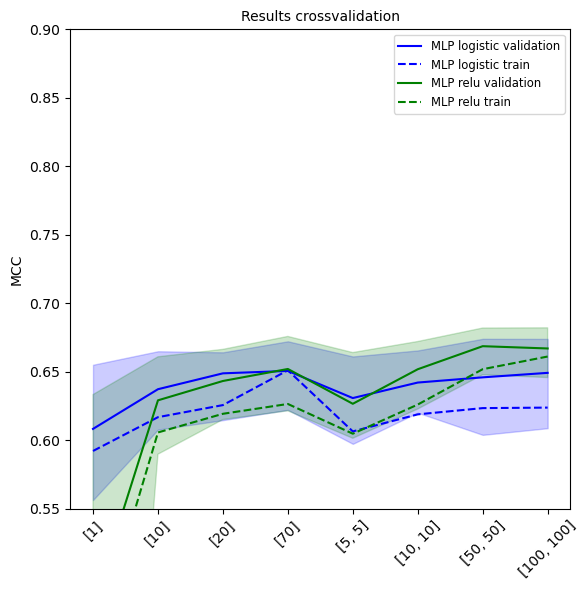

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
# ######################### Logistic 
# Plot results logistic activation function
mean_logistic_test = np.array([res_test_xval_logistic[i, :, learning_logistic[i], 
                           alpha_logistic[i]].mean() for i in range(res_test_xval_logistic.shape[0])])
min_logistic_test = np.array([res_test_xval_logistic[i, :, learning_logistic[i], 
                          alpha_logistic[i]].min() for i in range(res_test_xval_logistic.shape[0])])
max_logistic_test = np.array([res_test_xval_logistic[i, :, learning_logistic[i], 
                          alpha_logistic[i]].max() for i in range(res_test_xval_logistic.shape[0])])

steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_logistic_test, 'b', label =r'MLP logistic validation')
ax.fill_between(steps, min_logistic_test, max_logistic_test, color = 'blue', alpha=0.2)
mean_logistic_train = np.array([res_train_xval_logistic[i, :, learning_logistic[i], 
                            alpha_logistic[i]].mean() for i in range(res_test_xval_logistic.shape[0])])


steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_logistic_train, '--b', label = r'MLP logistic train')

# Plot results relu activation function
mean_relu_test = np.array([res_test_xval_relu[i, :, learning_relu[i], 
                           alpha_relu[i]].mean() for i in range(res_test_xval_relu.shape[0])])
min_relu_test = np.array([res_test_xval_relu[i, :, learning_relu[i], 
                          alpha_relu[i]].min() for i in range(res_test_xval_relu.shape[0])])
max_relu_test = np.array([res_test_xval_relu[i, :, learning_relu[i], 
                          alpha_relu[i]].max() for i in range(res_test_xval_relu.shape[0])])

steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_relu_test, 'g', label = r'MLP relu validation')
ax.fill_between(steps, min_relu_test, max_relu_test, color = 'green', alpha=0.2)

mean_relu_train = np.array([res_train_xval_relu[i, :, learning_relu[i], 
                            alpha_relu[i]].mean() for i in range(res_train_xval_relu.shape[0])])


steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_relu_train, '--g', label = r'MLP relu train')

ax.set_title('Results crossvalidation', fontsize= 10)

ax.set_ylim(0.55, 0.9)
ax.set_ylabel('MCC')
ax.set_xticks(np.arange(len(hidden_layer_sizes)), [str(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes))], rotation = 45)
ax.set_xticks(np.arange(len(hidden_layer_sizes)), [str(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes))], rotation = 45)
plt.tight_layout()

ax.legend(fontsize='small', loc='upper right')


## Train MLP using optimal hyperparameters and all CMLs

In [12]:
# prepare TRAIN dataset:
Y_train = np.vstack(np.array([(ds_cmls.sel(cml_id = train_test).isel( 
    cml_id = i, sublink_id = 0).gauge_wet).values.reshape(-1, 1) for i in range(
    ds_cmls.sel(cml_id = train_test).cml_id.size)]))

X_train = []
x_start = np.ones([int(windowsize/2), windowsize*2])*np.nan
x_end = np.ones([int(windowsize/2)- 1, windowsize*2])*np.nan

for link_i in range(ds_cmls.sel(cml_id = train_test).cml_id.size):
    sliding_window_ch1 = sliding_window_view(ds_cmls.sel(
        cml_id = train_test).isel(cml_id = link_i, sublink_id = 0).trsl_norm.values, window_shape = windowsize)
    sliding_window_ch2 = sliding_window_view(ds_cmls.sel(
        cml_id = train_test).isel(cml_id = link_i, sublink_id = 1).trsl_norm.values, window_shape = windowsize)

    X_train.append(np.vstack([x_start, np.hstack([sliding_window_ch1, sliding_window_ch2]), x_end]))
X_train = np.vstack(X_train)

# remove nan
indices = np.argwhere(~np.isnan(X_train).any(axis = 1)).ravel()
X_train = X_train[indices, :]
Y_train = Y_train[indices]

# # set minutes close to rain as wet, select 50/50 wet dry 
smoothed_rain = smooth_binary_array(Y_train.ravel(), window_size=30)
indices_rain = np.where(smoothed_rain)[0]
indices_norain = np.where(~smoothed_rain)[0]

# select some random dry events
indices_norain = np.random.choice(indices_norain, size = np.sum(smoothed_rain), replace = False, p = None)
X_train = np.vstack([X_train[indices_norain, :], X_train[indices_rain, :]])
Y_train = np.vstack([Y_train[indices_norain, :], Y_train[indices_rain, :]])

Y_onehot = onehot.fit_transform(Y_train)


In [13]:
i =  6 # optimal hidden layers, see article
hls = hidden_layer_sizes[i]
dnn = MLPClassifier(learning_rate_init= learning_rate[learning_relu[i]], # optimal learning rate for hls_i
                        alpha=regularization[alpha_relu[i]], # optimal alpha rate for hls_i
                        max_iter=200, 
                        activation='relu',
                        solver='adam',
                        verbose = False,
                        hidden_layer_sizes=hls)

dnn.fit(X_train, Y_onehot)

MLPClassifier(alpha=np.float64(0.175), hidden_layer_sizes=[50, 50],
              learning_rate_init=np.float64(0.00031622776601683794))

In [14]:
with open('model_rg.pkl','wb') as f:
    pickle.dump(dnn,f)